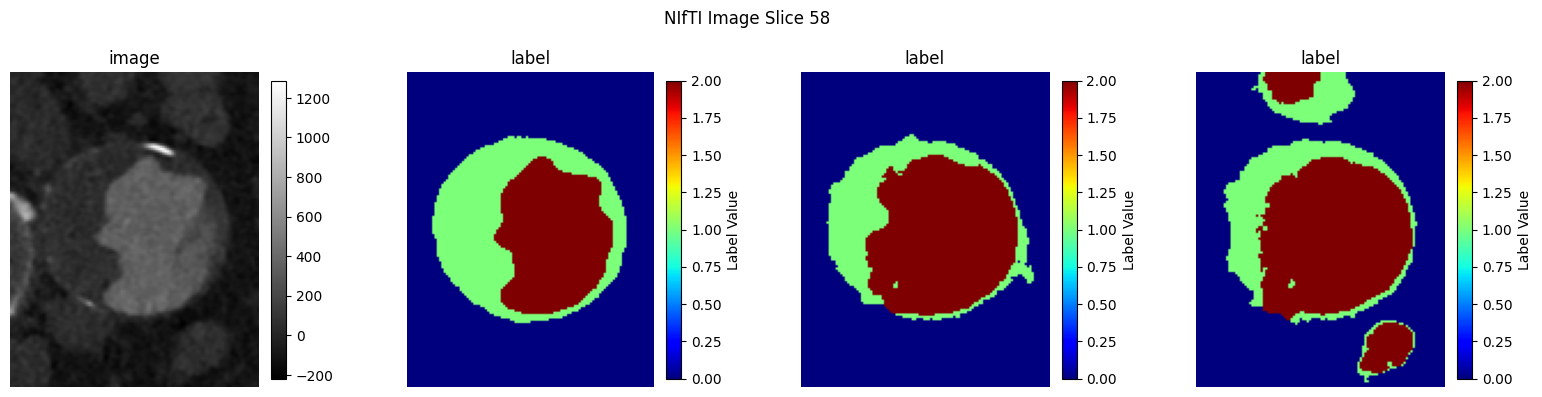

In [24]:

from utils.check_image import check_image
import nibabel as nib

image = nib.load(f"data/nnunet_raw/Dataset001_raw_aaa/imagesTs/aaa_020_0000.nii.gz").get_fdata()
ground_truth = nib.load(f"data/nnunet_raw/Dataset001_raw_aaa/labelsTs/aaa_020.nii.gz").get_fdata()
label0 = nib.load(f"data/nnunet_raw/Dataset003_perlin_aaa/outputTs/aaa_020.nii.gz").get_fdata()
label1 = nib.load(f"data/nnunet_raw/Dataset002_origin_synthseg/outputTs/aaa_020.nii.gz").get_fdata()
check_image(
    [
        {"image": image, "title": "image", "is_label": False},
        {"image": ground_truth, "title": "label", "is_label": True},
        {"image": label0, "title": "label", "is_label": True},
        {"image": label1, "title": "label", "is_label": True},
    ]
)


In [10]:

from utils.nrrd2nii import nrrd2nii
from utils.check_image import check_image
import nibabel as nib


image = nrrd2nii("data/uwa_aaa/Patient22/Segmentation/Patient 22 Crop.nrrd").get_fdata()
label0 = nrrd2nii(f"data/uwa_aaa/Patient22/Segmentation/ILT22.seg.nrrd").get_fdata()
label1 = nrrd2nii(f"data/uwa_aaa/Patient22/Segmentation/Lumen.seg.nrrd").get_fdata()
check_image(
    [
        {"image": image, "title": "image", "is_label": False},
        # {"image": ground_truth, "title": "label", "is_label": True},
        {"image": label0, "title": "label", "is_label": True},
        {"image": label1, "title": "label", "is_label": True},
    ]
)


interactive(children=(IntSlider(value=0, description='slice_index_0', max=333), IntSlider(value=0, description…


Results for ID 016:
--------------------------------------------------
Class 1:
  Raw: 0.3362
  Perlin: 0.0107
  SynthSeg: 0.0513
Class 2:
  Raw: 0.8724
  Perlin: 0.6913
  SynthSeg: 0.6926

Results for ID 017:
--------------------------------------------------
Class 1:
  Raw: 0.6581
  Perlin: 0.0103
  SynthSeg: 0.2496
Class 2:
  Raw: 0.8986
  Perlin: 0.7798
  SynthSeg: 0.2480

Results for ID 018:
--------------------------------------------------
Class 1:
  Raw: 0.7346
  Perlin: 0.0286
  SynthSeg: 0.0608
Class 2:
  Raw: 0.9177
  Perlin: 0.8229
  SynthSeg: 0.7827

Results for ID 019:
--------------------------------------------------
Class 1:
  Raw: 0.5097
  Perlin: 0.3193
  SynthSeg: 0.2749
Class 2:
  Raw: 0.8427
  Perlin: 0.6007
  SynthSeg: 0.6333

Results for ID 020:
--------------------------------------------------
Class 1:
  Raw: 0.8451
  Perlin: 0.6771
  SynthSeg: 0.5545
Class 2:
  Raw: 0.9512
  Perlin: 0.8902
  SynthSeg: 0.7244

Overall Mean Dice Scores:
-----------------------

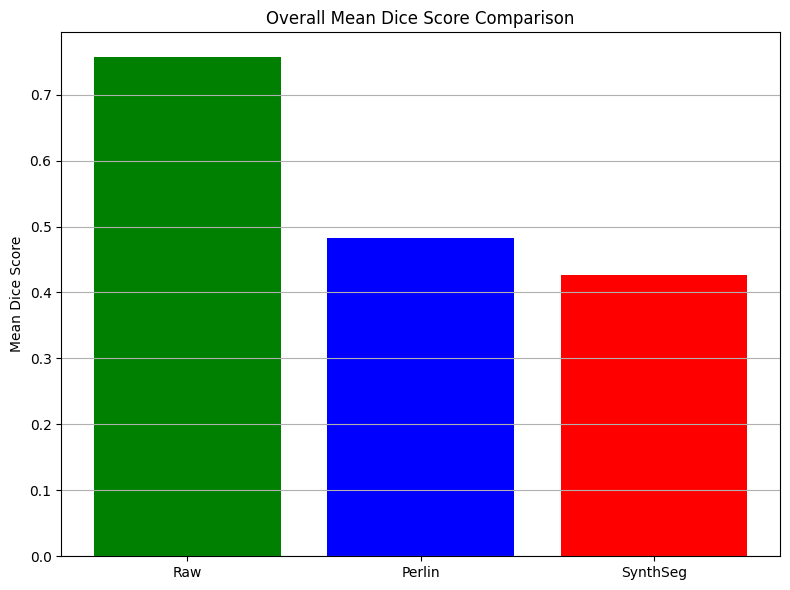

In [2]:
import nibabel as nib
import torch
import numpy as np
import matplotlib.pyplot as plt

def load_and_pad_label(file_path, reference_shape):
    """Load a NIfTI file and pad it to ensure even dimensions."""
    label = nib.load(file_path).get_fdata()
    padding = [(0, 1 if dim % 2 == 1 else 0) for dim in label.shape]
    label = np.pad(label, padding, mode="constant")
    return label

def calculate_dice_score(pred, target):
    """Calculate Dice score for a single class between prediction and target."""
    pred = torch.from_numpy(pred).float().flatten()
    target = torch.from_numpy(target).float().flatten()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection) / (union + 1e-8)  # Small epsilon to avoid division by zero
    return dice.item()

def compute_dice_scores(label, ground_truth):
    """Compute Dice scores for all classes (excluding background)."""
    num_classes = int(max(label.max(), ground_truth.max())) + 1
    dice_scores = []
    for class_id in range(1, num_classes):  # Skip background class (0)
        pred_class = (label == class_id).astype(int)
        target_class = (ground_truth == class_id).astype(int)
        dice_score = calculate_dice_score(pred_class, target_class)
        dice_scores.append(dice_score)
    return dice_scores

# Define IDs to process
ids = [f"{i:03d}" for i in range(16, 21)]  # 016 to 020
all_dice_raw = []
all_dice_perlin = []
all_dice_synthseg = []

# Process each ID
for id in ids:
    # File paths
    ground_truth_path = f"data/nnunet_raw/Dataset001_raw_aaa/labelsTs/aaa_{id}.nii.gz"
    label_raw_path = f"data/nnunet_raw/Dataset001_raw_aaa/outputTs/aaa_{id}.nii.gz"
    label_perlin_path = f"data/nnunet_raw/Dataset003_perlin_aaa/outputTs/aaa_{id}.nii.gz"
    label_synthseg_path = f"data/nnunet_raw/Dataset002_origin_synthseg/outputTs/aaa_{id}.nii.gz"

    # Load data
    ground_truth = nib.load(ground_truth_path).get_fdata()
    label_raw = load_and_pad_label(label_raw_path, ground_truth.shape)
    label_perlin = load_and_pad_label(label_perlin_path, ground_truth.shape)
    label_synthseg = load_and_pad_label(label_synthseg_path, ground_truth.shape)

    # Compute Dice scores
    dice_scores_raw = compute_dice_scores(label_raw, ground_truth)
    dice_scores_perlin = compute_dice_scores(label_perlin, ground_truth)
    dice_scores_synthseg = compute_dice_scores(label_synthseg, ground_truth)

    # Append to lists
    all_dice_raw.extend(dice_scores_raw)
    all_dice_perlin.extend(dice_scores_perlin)
    all_dice_synthseg.extend(dice_scores_synthseg)

    # Print results for current ID
    print(f"\nResults for ID {id}:")
    print("-" * 50)
    for class_id, (dice_raw, dice_perlin, dice_synthseg) in enumerate(zip(dice_scores_raw, dice_scores_perlin, dice_scores_synthseg), 1):
        print(f"Class {class_id}:")
        print(f"  Raw: {dice_raw:.4f}")
        print(f"  Perlin: {dice_perlin:.4f}")
        print(f"  SynthSeg: {dice_synthseg:.4f}")

# Calculate mean Dice scores across all IDs
mean_dice_raw = sum(all_dice_raw) / len(all_dice_raw) if all_dice_raw else 0
mean_dice_perlin = sum(all_dice_perlin) / len(all_dice_perlin) if all_dice_perlin else 0
mean_dice_synthseg = sum(all_dice_synthseg) / len(all_dice_synthseg) if all_dice_synthseg else 0

# Print overall mean Dice scores
print("\nOverall Mean Dice Scores:")
print("-" * 50)
print(f"Raw: {mean_dice_raw:.4f}")
print(f"Perlin: {mean_dice_perlin:.4f}")
print(f"SynthSeg: {mean_dice_synthseg:.4f}")

# Generate bar chart
plt.figure(figsize=(8, 6))
labels = ['Raw', 'Perlin', 'SynthSeg']
mean_scores = [mean_dice_raw, mean_dice_perlin, mean_dice_synthseg]
colors = ['green', 'blue', 'red']

plt.bar(labels, mean_scores, color=colors)
plt.ylabel('Mean Dice Score')
plt.title('Overall Mean Dice Score Comparison')
plt.grid(True, axis='y')
plt.tight_layout()

# Save plot
plt.savefig('mean_dice_score_comparison.png')